In [1]:
import pandas as pd

In [5]:
output = pd.read_csv('../../data/downloads/freight_comparison_report.csv')

In [6]:
output.columns

Index(['site', 'invoice_id', 'freight_price', 'unique_commodity_group_input',
       'unique_commodity_description_input', 'total_estimated_area_cost',
       'total_estimated_cwt_cost', 'total_est_lbs', 'total_est_sqyd',
       'unique_commodity_group_output', 'unique_commodity_description_output',
       'total_cost', 'total_quantity', 'UOM', 'freight_ratio', 'market_rate',
       'xgs_rate', 'shipment_type'],
      dtype='object')

In [8]:
output = output.replace([float('inf'), float('-inf')], pd.NA).dropna()

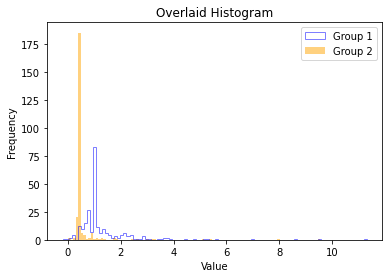

In [36]:
import matplotlib.pyplot as plt

# Sample data

filtered_output = output[output['unique_commodity_group_input'] == "['1CBL']"]

# Overlaid histogram
plt.hist(filtered_output['market_rate'], bins=100, alpha=0.5, label="Group 1", color="blue",histtype='step')
plt.hist(filtered_output['xgs_rate'], bins=100, alpha=0.5, label="Group 2", color="orange")

plt.legend()
plt.title("Overlaid Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter data
filtered_output = output[output['unique_commodity_group_input'] == "['1CBL']"]

# Define bins
bins = np.linspace(min(filtered_output[['market_rate', 'xgs_rate']].min()),
                   max(filtered_output[['market_rate', 'xgs_rate']].max()), 100)

# Compute histogram values
market_counts, market_bins = np.histogram(filtered_output['market_rate'], bins=bins)
xgs_counts, xgs_bins = np.histogram(filtered_output['xgs_rate'], bins=bins)

# Use bin centers for plotting/export
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Create DataFrame for Excel
hist_df = pd.DataFrame({
    "bin_center": bin_centers,
    "market_rate_count": market_counts,
    "xgs_rate_count": xgs_counts
})

# Display in console
print(hist_df)

# Save to Excel or CSV
hist_df.to_csv("histogram_data_1CBL.csv", index=False)


    bin_center  market_rate_count  xgs_rate_count
0    -0.141869                  1               0
1    -0.025606                  1               2
2     0.090657                  2               0
3     0.206919                  4               0
4     0.323182                  0              21
..         ...                ...             ...
94   10.786818                  0               0
95   10.903081                  0               0
96   11.019343                  0               0
97   11.135606                  0               0
98   11.251869                  1               0

[99 rows x 3 columns]


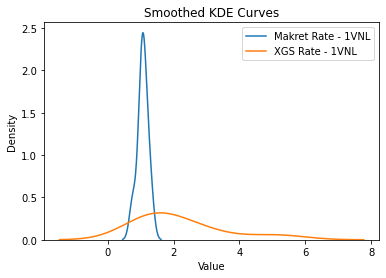

In [32]:
import seaborn as sns

filtered_output = output[(output['market_rate'] >= 1) & (output['market_rate'] <= 1.50)]
filtered_output = output[(output['xgs_rate'] >= 1) & (output['market_rate'] <= 1.50)]
filtered_output = filtered_output[filtered_output['unique_commodity_group_input'] == "['1CBL']"]


sns.kdeplot(filtered_output['market_rate'], label="Makret Rate - 1VNL", fill=False)
sns.kdeplot(filtered_output['xgs_rate'], label="XGS Rate - 1VNL", fill=False)

plt.title("Smoothed KDE Curves")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

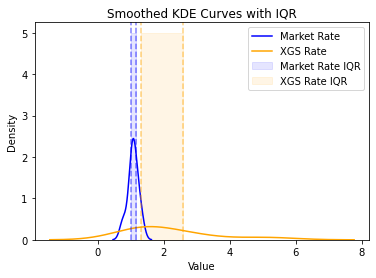

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

filtered_output = output[(output['market_rate'] >= 1) & (output['market_rate'] <= 1.50)]
filtered_output = output[(output['xgs_rate'] >= 1) & (output['market_rate'] <= 1.50)]
filtered_output = filtered_output[filtered_output['unique_commodity_group_input'] == "['1CBL']"]

# Example data
market_rate = filtered_output['market_rate']

xgs_rate = filtered_output['xgs_rate']

# Plot KDEs
sns.kdeplot(market_rate, label="Market Rate", color="blue", fill=False)
sns.kdeplot(xgs_rate, label="XGS Rate", color="orange", fill=False)

# Compute and plot IQRs
for data, color, label in [(market_rate, 'blue', 'Market Rate'), (xgs_rate, 'orange', 'XGS Rate')]:
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    plt.axvline(q1, color=color, linestyle='--', alpha=0.5)
    plt.axvline(q3, color=color, linestyle='--', alpha=0.5)
    plt.fill_betweenx([0, 5], q1, q3, color=color, alpha=0.1, label=f"{label} IQR")

plt.title("Smoothed KDE Curves with IQR")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


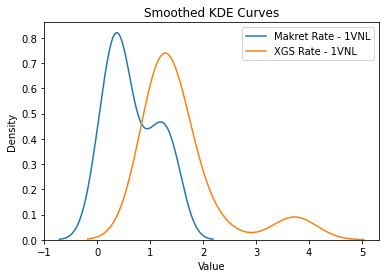

In [31]:
import seaborn as sns

filtered_output = output[(output['market_rate'] >= 1) & (output['market_rate'] <= 1.50)]
filtered_output = output[(output['xgs_rate'] >= 1) & (output['market_rate'] <= 1.50)]
filtered_output = filtered_output[filtered_output['unique_commodity_group_input'] == "['1VNL']"]


sns.kdeplot(filtered_output['market_rate'], label="Makret Rate - 1VNL", fill=False)
sns.kdeplot(filtered_output['xgs_rate'], label="XGS Rate - 1VNL", fill=False)

plt.title("Smoothed KDE Curves")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
print(filtered_output)

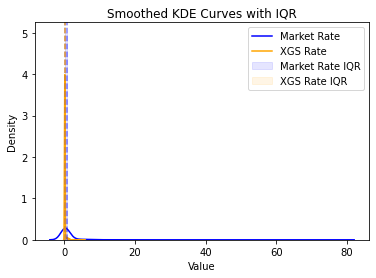

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
market_rate = filtered_output['market_rate']

xgs_rate = filtered_output['xgs_rate']

# Plot KDEs
sns.kdeplot(market_rate, label="Market Rate", color="blue", fill=False)
sns.kdeplot(xgs_rate, label="XGS Rate", color="orange", fill=False)

# Compute and plot IQRs
for data, color, label in [(market_rate, 'blue', 'Market Rate'), (xgs_rate, 'orange', 'XGS Rate')]:
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    plt.axvline(q1, color=color, linestyle='--', alpha=0.5)
    plt.axvline(q3, color=color, linestyle='--', alpha=0.5)
    plt.fill_betweenx([0, 5], q1, q3, color=color, alpha=0.1, label=f"{label} IQR")

plt.title("Smoothed KDE Curves with IQR")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


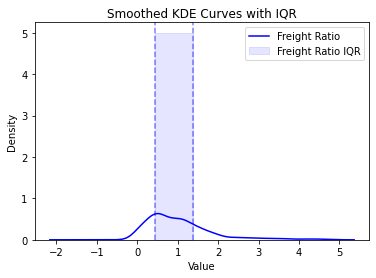

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
filtered_output = output[output['freight_ratio']<5]
market_rate = filtered_output['freight_ratio']

# Plot KDEs
sns.kdeplot(market_rate, label="Freight Ratio", color="blue", fill=False)

# Compute and plot IQRs
for data, color, label in [(market_rate, 'blue', 'Freight Ratio'), ]:
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    plt.axvline(q1, color=color, linestyle='--', alpha=0.5)
    plt.axvline(q3, color=color, linestyle='--', alpha=0.5)
    plt.fill_betweenx([0, 5], q1, q3, color=color, alpha=0.1, label=f"{label} IQR")

plt.title("Smoothed KDE Curves with IQR")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()
